## Declarations

### Imports

In [1]:
import os
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '2'

import tensorflow as tf
import numpy as np
import random
from IPython.display import display
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import seaborn as sns
import pandas as pd
from sklearn.model_selection import train_test_split
from tqdm import tqdm

tfk = tf.keras
tfkl = tf.keras.layers
kb = tf.keras.backend
print(tf.__version__)
print("Num GPUs Available: ", len(tf.config.list_physical_devices('GPU')))

2.11.0
Num GPUs Available:  1


In [2]:
def split(x1, x2, test_size=0.2, val_size=0.0, seed=0):
    if val_size + test_size >= 1:
        return None
    x1_train, x1_test, x2_train, x2_test = train_test_split(
        x1, x2, test_size=test_size + val_size, random_state=seed
    )
    x1_val = None
    x2_val = None
    if val_size > 0:
        x1_test, x1_val, x2_test, x2_val = train_test_split(
            x1,
            x2,
            test_size=val_size / (test_size + val_size),
            random_state=seed,
        )
    return x1_train, x1_val, x1_test, x2_train, x2_val, x2_test


def create_dataset(x1, x2, vectorization=None):

    if x1 is None or x2 is None:
        return None 

    dataset = tf.data.Dataset.from_tensor_slices((x1, x2))

    if vectorization is None:
        return dataset.map(lambda i, c: {'image': i, 'caption': c})
    
    else:
        return dataset.map(lambda i, c: {'image': i, 'caption': vectorization(c)})
    

def custom_standardization(input_string):
    # convert input string to lowercase
    lowercase = tf.strings.lower(input_string)
    # replace special characters with empty string
    # TODO
    #return tf.strings.regex_replace(lowercase, "[%s]" % re.escape(strip_chars), "")
    return lowercase
    

### Constants

In [3]:
# Random seed for reproducibility
seed = 42

random.seed(seed)
os.environ['PYTHONHASHSEED'] = str(seed)
np.random.seed(seed)
tf.random.set_seed(seed)
tf.compat.v1.set_random_seed(seed)

image_dir = "./resized_train"
caption_pred_file = "caption_prediction_train.csv"
concept_det_file = "concept_detection_train.csv"
concept_file = "concepts.csv"

image_size = (128, 128, 3)

batch_size = 10
epochs = 100

## Preprocessing

### File Reading and Pre-processing

In [4]:
captions_df = pd.read_csv(caption_pred_file, sep='\t')

# Usually if we extract a string from the dataframe it will get truncated to 
# 50 characters. This way instead we select the longest string in the dataframe and
# use that as max truncation. This means that no string will be truncated
max_len = captions_df.caption.str.len().max()
pd.set_option('display.max_colwidth', int(max_len))

# Ad [SOS] and [EOS] tokens at the beginning and end of every caption.
captions_df['caption'] = captions_df['caption'].map('[SOS] {} [EOS]'.format)

# Compute size of vocabulary
result = ""
for i in captions_df['caption'].to_numpy():
    result += " " + i
result = custom_standardization(result)
result = bytes.decode(result.numpy())
vocab_size = len(set(result.split()))
print(f"Vocab size: {vocab_size}")

# Compute longest sequence
idx = captions_df.caption.str.len().idxmax()
longest = captions_df['caption'][idx]
longest = custom_standardization(longest)
longest = bytes.decode(longest.numpy())
longest = longest.split()
sequence_length = len(longest)
print(f"Longest sequence: {sequence_length}")

Vocab size: 35491
Longest sequence: 393


In [5]:
# Get the filenames of the images
image_filenames = sorted(os.listdir(image_dir))
num_images = len(image_filenames)

# Pre-allocate the whole numpy array to store images
images = np.zeros((num_images, image_size[0], image_size[1], image_size[2]), dtype=np.float16)

captions = []

# Iterate over the dataframe and match the images with captions
for i, image_filename in enumerate(tqdm(image_filenames)):
    
    # Extract the image ID from the filename
    image_id = image_filename.split('.')[0]

    # Load image
    image_path = image_dir + '/' + image_filename
    image = tf.keras.preprocessing.image.load_img(image_path, target_size=(image_size[0], image_size[1]))
    image = tf.keras.preprocessing.image.img_to_array(image, dtype='float16')
    image /= 255.0

    # Insert image in array
    images[i] = image

    # Find corresponding caption
    caption = captions_df[captions_df['ID'] == image_id]['caption'].to_string(index=False)
    captions.append(caption)

  0%|          | 0/83275 [00:00<?, ?it/s]

100%|██████████| 83275/83275 [06:31<00:00, 212.53it/s]


In [6]:
train_images, val_images, test_images, train_captions, val_captions, test_captions = split(
        images, captions, test_size=0.2, seed=seed
    )

# Free unused memory
del captions, images

In [7]:
# Train a vectorizer on the raw captions of the train dataset
text_vectorization = tfkl.TextVectorization(
    max_tokens=vocab_size,
    output_mode="int",
    output_sequence_length=sequence_length,
    standardize=custom_standardization,
)

text_vectorization.adapt(train_captions)

In [8]:
train_ds = create_dataset(train_images, train_captions, vectorization=text_vectorization)
val_ds = create_dataset(val_images, val_captions, vectorization=text_vectorization)
test_ds = create_dataset(test_images, test_captions, vectorization=text_vectorization)

Instructions for updating:
Lambda fuctions will be no more assumed to be used in the statement where they are used, or at least in the same block. https://github.com/tensorflow/tensorflow/issues/56089


In [9]:
del train_images, val_images, test_images, train_captions, val_captions, test_captions

## Network

### Network blocks

In [10]:
def CNN_embedding(input_shape, latent_dim, embed_dim, seed, supernet=None, preprocessing=None):
    tf.random.set_seed(seed)
    input_layer = tfkl.Input(shape=input_shape, name='img_input_layer')
    
    if not supernet:
        x = tfkl.ZeroPadding2D((2,2))(input_layer)

        x = tfkl.Conv2D(64, 3, padding='same', strides=2)(x)
        x = tfkl.BatchNormalization()(x)
        x = tfkl.ReLU()(x)

        x = tfkl.Conv2D(128, 3, padding='same', strides=2)(x)
        x = tfkl.BatchNormalization()(x)
        x = tfkl.ReLU()(x)

        x = tfkl.Conv2D(256, 3, padding='same', strides=2)(x)
        x = tfkl.BatchNormalization()(x)
        x = tfkl.ReLU()(x)

        x = tfkl.Conv2D(512, 3, padding='same', strides=2)(x)
        x = tfkl.BatchNormalization()(x)
        x = tfkl.ReLU()(x)


    else:
        x = preprocessing(input_layer)
        x = supernet(x)

    x = tfkl.GlobalAveragePooling2D(name='GAP')(x)
    x = tfkl.Dense(latent_dim, activation='relu')(x)
    x = tfkl.Dense(embed_dim, name='img_embedding_output_layer')(x)

    # Connect input and output through the Model class
    cnn_encoder = tfk.Model(inputs=input_layer, outputs=x, name='image_encoder')

    # Return the discriminator
    return cnn_encoder

In [11]:
class TokenAndPositionEmbedding(tfkl.Layer):
    def __init__(self, maxlen, vocab_size, embed_dim, **kwargs):
        super().__init__(**kwargs)
        # Embedding layer for the token
        self.token_emb = tfkl.Embedding(input_dim=vocab_size, output_dim=embed_dim)
        # Embedding layer for the position
        self.pos_emb = tfkl.Embedding(input_dim=maxlen, output_dim=embed_dim)

    def call(self, x):
        # Find the maximum length of the input
        maxlen = tf.shape(x)[-1]
        # Create a tensor with positions from 0 to maxlen-1
        positions = tf.range(start=0, limit=maxlen, delta=1)
        # Embed the positions
        positions = self.pos_emb(positions)
        # Embed the tokens
        x = self.token_emb(x)
        # Add the token and position embeddings
        return x + positions

In [12]:
class TransformerEncoderBlock(tfkl.Layer):
    def __init__(self, embed_dim, num_heads, ff_dim, rate=0.1, **kwargs):
        super().__init__(**kwargs)
        self.att = tfkl.MultiHeadAttention(num_heads=num_heads, key_dim=embed_dim)
        self.ffn = tfk.Sequential(
            [
                tfkl.Dense(ff_dim, activation="relu"), 
                tfkl.Dense(embed_dim)
            ]
        )
        self.layernorm1 = tfkl.LayerNormalization(epsilon=1e-6)
        self.layernorm2 = tfkl.LayerNormalization(epsilon=1e-6)
        self.dropout1 = tfkl.Dropout(rate)
        self.dropout2 = tfkl.Dropout(rate)
        
    def call(self, inputs, training):
        # Self-attention
        attn_output = self.att(inputs, inputs)
        # Apply dropout to the attention output
        attn_output = self.dropout1(attn_output, training=training)
        # Add the attention output to the input and normalize
        out1 = self.layernorm1(inputs + attn_output)
        # Feed-forward
        ffn_output = self.ffn(out1)
        # Apply dropout to the feed-forward output
        ffn_output = self.dropout2(ffn_output, training=training)
        # Add the feed-forward output to the previous output and normalize
        return self.layernorm2(out1 + ffn_output)

In [13]:
def text_embedding(sequence_lenght, vocab_size, num_heads, embed_dim, latent_dim):
    input_layer = tfk.Input(shape=(None,), dtype="int64", name="text_inputs")
    x = TokenAndPositionEmbedding(sequence_lenght, vocab_size, embed_dim)(input_layer)
    x = TransformerEncoderBlock(embed_dim, num_heads, latent_dim)(x)
    
    text_encoder = tfk.Model(input_layer, x)
    
    return text_encoder

In [14]:
class CLIP(tfk.Model):
    def __init__(self, image_encoder, text_encoder, temp=0.07, **kwargs):
        super().__init__(**kwargs)
        self.image_encoder = image_encoder
        self.text_encoder = text_encoder
        self.temp = temp
        self.loss_tracker = tfk.metrics.Mean(name="loss")

    @property
    def metrics(self):
        return [self.loss_tracker]

    def call(self, features, training=False):
        image_emb = self.image_encoder(features["image"], training=training)
        text_emb = self.text_encoder(features["caption"], training=training)
        return image_emb, text_emb

    def CLIP_loss(self, image_emb, text_emb):
        norm_image_emb = tf.math.l2_normalize(image_emb, axis=1)
        norm_text_emb = tf.math.l2_normalize(text_emb, axis=1)

        logits = tf.linalg.matmul(norm_image_emb, norm_text_emb, transpose_b=True) * tf.math.exp(self.temp)

        n = tf.shape(logits)[0]
        labels = tf.range(n)

        loss_img = tfk.losses.sparse_categorical_crossentropy(labels, logits, from_logits=True)
        loss_txt = tfk.losses.sparse_categorical_crossentropy(labels, kb.transpose(logits), from_logits=True)

        return (loss_img + loss_txt) / tf.constant(2.0)

    def train_step(self, features):
        with tf.GradientTape() as tape:
            image_embeddings, caption_embeddings = self(features, training=True)
            loss = self.CLIP_loss(caption_embeddings, image_embeddings)

        gradients = tape.gradient(loss, self.trainable_variables)
        self.optimizer.apply_gradients(zip(gradients, self.trainable_variables))

        self.loss_tracker.update_state(loss)
        return {"loss": self.loss_tracker.result()}

    def test_step(self, features):
        image_embeddings, caption_embeddings = self(features, training=False)
        loss = self.CLIP_loss(caption_embeddings, image_embeddings)
        self.loss_tracker.update_state(loss)
        return {"loss": self.loss_tracker.result()}


### Building network

In [15]:
def build_clip(img_input_shape=(128, 128, 3),
               txt_input_shape=(393, ), 
               latent_dim=1024, 
               embed_dim=128, 
               seq_lenght=393, 
               vocab_size=35491, 
               num_heads=4,
               temp=0.07,
               supernet=None,
               preprocessing=None):
    
    img_input = tfk.Input(shape=img_input_shape)
    txt_input = tfk.Input(shape=txt_input_shape)
    
    img_embed = CNN_embedding(img_input_shape, latent_dim, embed_dim, seed=42, supernet=supernet, preprocessing=preprocessing)(img_input)
    image_encoder = tfk.Model(img_input, img_embed, name = "image_encoder")

    txt_embed = text_embedding(seq_lenght, vocab_size, num_heads, embed_dim, latent_dim)(txt_input)
    txt_embed = tfkl.GlobalAveragePooling1D()(txt_embed)
    txt_embed = tfkl.Dense(embed_dim, name="text_encoder")(txt_embed)
    text_encoder = tfk.Model(txt_input, txt_embed, name = "text_encoder")

    clip = CLIP(image_encoder, text_encoder, temp)
    clip.compile(optimizer = tf.optimizers.Adam())
    return image_encoder, text_encoder, clip

In [16]:
# Build clip with a CNN from scratch
image_encoder, text_encoder, clip = build_clip()

# Build clip with a frozen convnext
#image_encoder, text_encoder, clip = build_clip(
#    supernet=tfk.applications.ConvNeXtTiny(weights='imagenet', include_top=False), 
#    preprocessing=tfk.applications.convnext.preprocess_input
#    )

#clip.summary()

## Training

### CLIP pre-training

In [17]:
# Create a learning rate scheduler callback.
reduce_lr = tfk.callbacks.ReduceLROnPlateau(
    monitor = "val_loss", factor = 0.2, patience = 3
)

# Create an early stopping callback.
early_stopping = tf.keras.callbacks.EarlyStopping(
    monitor = "val_loss", patience = 5, restore_best_weights = True
)


history = clip.fit(
    train_ds.batch(batch_size),
    epochs = epochs,
    validation_data = test_ds.batch(batch_size),
    callbacks = [reduce_lr, early_stopping],
)

Epoch 1/100
6662/6662 [==============================] - 113s 16ms/step - loss: 2.2316 - val_loss: 2.3273 - lr: 0.0010
Epoch 2/100
6662/6662 [==============================] - 97s 14ms/step - loss: 1.9391 - val_loss: 1.9015 - lr: 0.0010
Epoch 3/100
6662/6662 [==============================] - 96s 14ms/step - loss: 1.8261 - val_loss: 1.8275 - lr: 0.0010
Epoch 4/100
6662/6662 [==============================] - 95s 14ms/step - loss: 1.7654 - val_loss: 1.8349 - lr: 0.0010
Epoch 5/100
6662/6662 [==============================] - 96s 14ms/step - loss: 1.7306 - val_loss: 1.7779 - lr: 0.0010
Epoch 6/100
6662/6662 [==============================] - 97s 15ms/step - loss: 1.7039 - val_loss: 1.7737 - lr: 0.0010
Epoch 7/100
6662/6662 [==============================] - 96s 14ms/step - loss: 1.6814 - val_loss: 1.7797 - lr: 0.0010
Epoch 8/100
6662/6662 [==============================] - 96s 14ms/step - loss: 1.6598 - val_loss: 1.7677 - lr: 0.0010
Epoch 9/100
6662/6662 [==============================] 

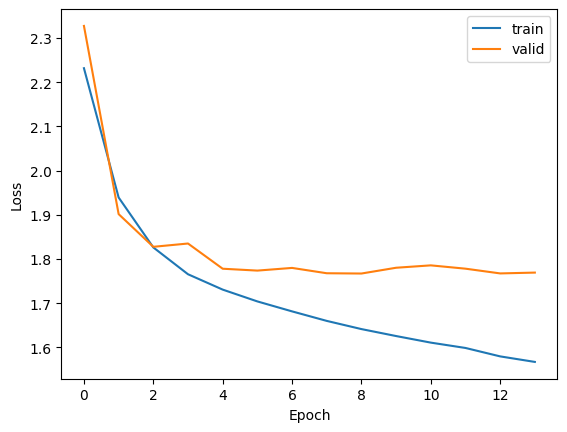

In [18]:
plt.plot(history.history["loss"])
plt.plot(history.history["val_loss"])
plt.ylabel("Loss")
plt.xlabel("Epoch")
plt.legend(["train", "valid"], loc="upper right")
plt.show()

In [19]:
clip.save("keras_clip_model")

INFO:tensorflow:Assets written to: keras_clip_model/assets


INFO:tensorflow:Assets written to: keras_clip_model/assets


### Encoder/Decoder training

In [20]:
def read_image(image_path):
    image_array = tf.image.decode_jpeg(tf.io.read_file(image_path), channels=3)
    return image_array

In [21]:
def find_matches(image_embeddings, queries, k=5, normalize=True):
    queries_vec = [text_vectorization(query) for query in queries]
    queries_vec = tf.data.Dataset.from_tensor_slices(queries_vec).batch(batch_size)
    # Get the embedding for the query.
    query_embedding = text_encoder.predict(queries_vec)
    # Normalize the query and the image embeddings.
    if normalize:
        image_embeddings = tf.math.l2_normalize(image_embeddings, axis=1)
        query_embedding = tf.math.l2_normalize(query_embedding, axis=1)
    # Compute the dot product between the query and the image embeddings.
    dot_similarity = tf.matmul(query_embedding, image_embeddings, transpose_b=True)
    # Retrieve top k indices.
    results = tf.math.top_k(dot_similarity, k).indices.numpy()
    # Return matching image paths.
    return [[train_image_paths[idx] for idx in indices] for indices in results]

In [22]:
train_data = [p for p in ds_train]
val_data = [p for p in ds_val]
test_data = [p for p in ds_test]

train_image_paths = [e["image path"] for e in train_data]
test_image_paths = [e["image path"] for e in test_data]

# TODO: this part only generates embeddings on the training dataset for now
# TODO: this code re-reads the images
image_embeddings = image_encoder.predict(
    tf.data.Dataset.from_tensor_slices(train_image_paths).map(read_image).batch(batch_size),
    verbose=1,
)
print(f"Image embeddings shape: {image_embeddings.shape}.")


NameError: name 'ds_train' is not defined

In [ ]:
query = "active pheochromocytoma"
matches = find_matches(image_embeddings, [query], normalize=True)[0]

print("Top matches for query: \"" + query + "\"")

plt.figure(figsize=(18, 18))
for i in range(9):
    path = matches[i].numpy().decode('UTF-8')
    caption = next(x["raw caption"] for x in train_data if x["image path"].numpy().decode('UTF-8') == path)
    ax = plt.subplot(3, 3, i + 1)
    plt.imshow(mpimg.imread(path))
    plt.axis("off")
    print(caption)


## Evaluation

In [ ]:
# TODO: might not work, needs revising

def compute_top_k_accuracy(image_paths, k=5):
    hits = 0
    num_batches = int(np.ceil(len(image_paths) / batch_size))
    for idx in range(num_batches):
        start_idx = idx * batch_size
        end_idx = start_idx + batch_size
        current_image_paths = image_paths[start_idx:end_idx]
        queries = [ captions[os.path.splitext(image_path.numpy().decode('UTF-8').split(os.sep)[-1])[0]] for image_path in current_image_paths ]
        result = find_matches(image_embeddings, queries, k)
        hits += sum(
            [
                image_path in matches for (image_path, matches) in list(zip(current_image_paths, result))
            ]
        )

    return hits / len(image_paths)

n = 1920

print(test_image_paths)

print("Scoring training data...")
train_accuracy = compute_top_k_accuracy(random.sample(train_image_paths, n))
print(f"Train accuracy: {round(train_accuracy * 100, 3)}%")

print("Scoring evaluation data...")
eval_accuracy = compute_top_k_accuracy(random.sample(test_image_paths, n))
print(f"Eval accuracy: {round(eval_accuracy * 100, 3)}%")
